In [89]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [380]:
include("dynamics.jl")
include("planner_utils.jl")
include("utils.jl")
include("planner.jl")
include("plotting.jl")
using Gurobi
const GRB_ENV = Gurobi.Env()

animation (generic function with 1 method)

### Interaction planner

In [417]:
dt = 0.1
velocity_max = 2.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1.0, 2.])

time_horizon = 30
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([0.5; 0.1]) 
Qt = diagm([3.; 3.; 0.])
markup = 1.
collision_slack = 100.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 0.75
inconvenience_ratio = 0.01


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 2.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 1.; 1.])
R = diagm([0.5; 0.1]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 30
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0]
  R: Array{Float64}((2, 2)) [0.5 0.0; 0.0 0.1]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.0
  collision_slack: Float64 100.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 0.75
  inconvenience_ratio: Float64 0.01


In [418]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; -pi]
human_goal_state = [0.; 0.; -pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [419]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=3, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=3, verbose=false, keep_history=false);



  0.037979 seconds (151.76 k allocations: 14.591 MiB)
  0.035952 seconds (139.13 k allocations: 12.668 MiB)


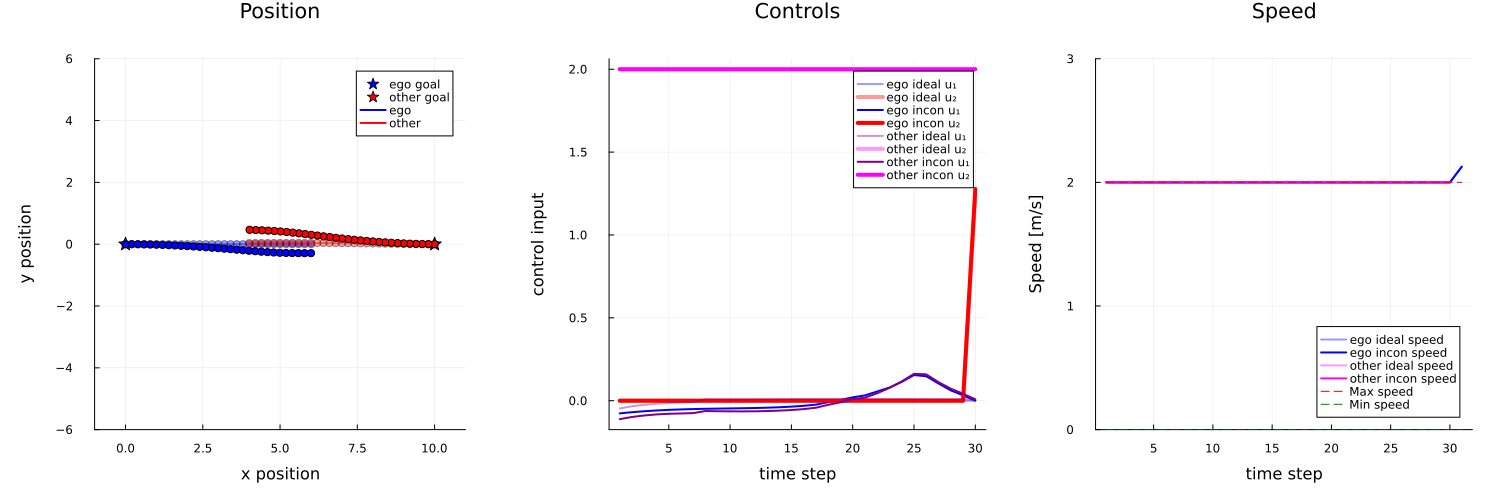

In [420]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Iterated Best Response

In [421]:
@time IteratedBestResponse(ip, 3, "")

  0.106110 seconds (298.67 k allocations: 27.277 MiB, 28.66% gc time)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


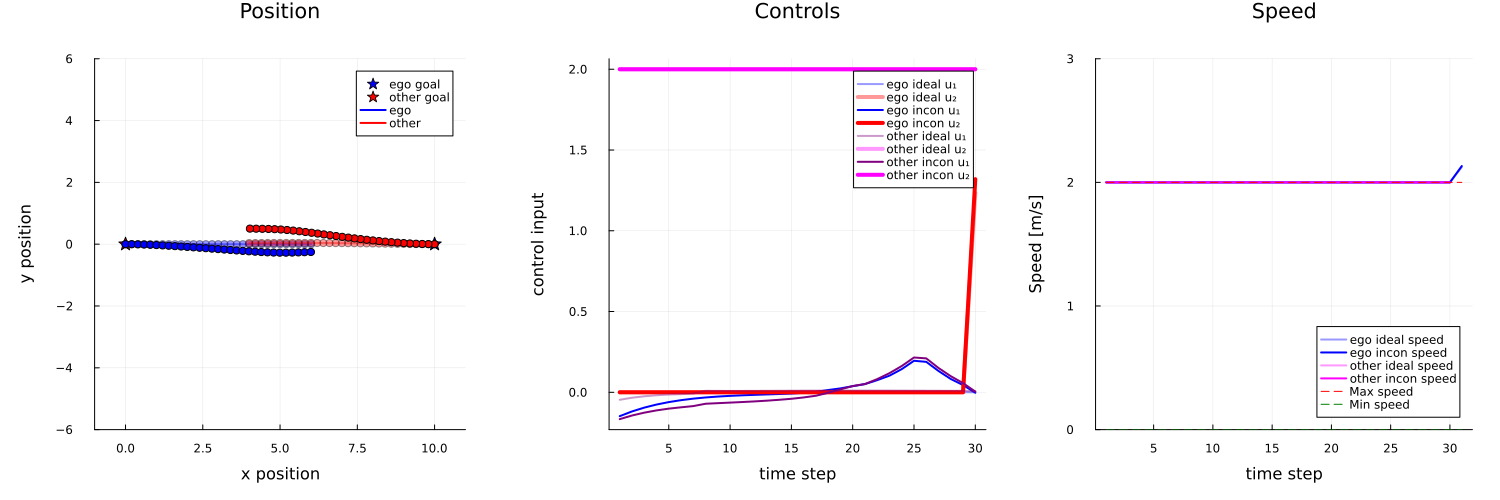

In [427]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Animation

Int64

┌ Info: Saved animation to /tmp/jl_nILeR230hm.gif
└ @ Plots /home/trajopt/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_nILeR230hm.gif")
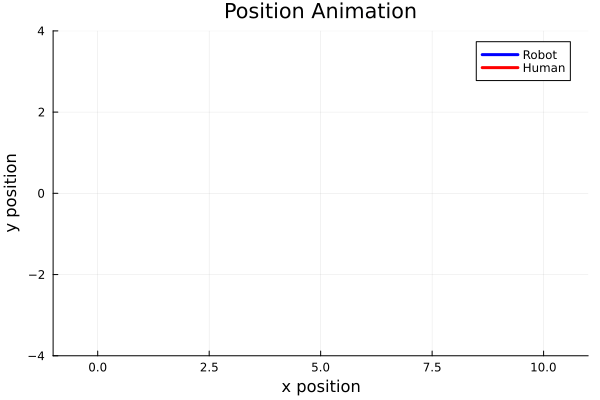

In [428]:
animation(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])

In [249]:
function IteratedBestResponseMPC(ip::InteractionPlanner, iterations::Int64, leader="ego"::String)
    if leader != "ego"                       # determine which agent solves leader
        leader_agent = ip.other_planner
        follower_agent = ip.ego_planner
    else
        leader_agent = ip.ego_planner
        follower_agent = ip.other_planner
    end

    # ideal_path computation for ego and other
    # update previous states and controls with ego's previous ideal solution adapted for next timepoint
    _ = popfirst!(ip.ego_planner.incon.opt_params.previous_states)                                                  # remove first entry
    push!(ip.ego_planner.incon.opt_params.previous_states, ip.ego_planner.incon.opt_params.previous_states[end])    # copy last entry and push to states

    # opt_params.inconvenience_budget for ego and other

    for i in 1:iterations
        
        # linearize collision avoidance constraints
        # linearize dynamics
        # update JuMP model
        # update previous state and controls with latest solution
        leader_agent.incon.opt_params.other_positions = get_position(follower_agent.incon.hps.dynamics, follower_agent.incon.opt_params.previous_states)
        solve(leader_agent.incon, iterations=1)
        follower_agent.incon.opt_params.other_positions = get_position(leader_agent.incon.hps.dynamics, leader_agent.incon.opt_params.previous_states)
        solve(follower_agent.incon, iterations=1)
    end

    # ip, value.(ip.ego_planner.incon.xs), value.(ip.ego_planner.incon.us), value.(ip.ego_planner.incon.us)[1]
    ip
end

IteratedBestResponseMPC (generic function with 2 methods)

In [424]:
solution_summary(ip.ego_planner.incon.model)

* Solver : ECOS

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Problem solved to optimality"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 2.81183e+02
  Dual objective value : 2.81183e+02

* Work counters
  Solve time (sec)   : 7.51814e-03
  Barrier iterations : 24


In [426]:
solution_summary(ip.other_planner.incon.model)

* Solver : ECOS

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Problem solved to optimality"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 6.15558e+01
  Dual objective value : 6.15560e+01

* Work counters
  Solve time (sec)   : 6.59891e-03
  Barrier iterations : 29
